In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor
from torch.utils.data import DataLoader, Dataset

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(3 * 64 * 64, 400)
#         self.fc21 = nn.Linear(400, 20)
#         self.fc22 = nn.Linear(400, 20)

#     def forward(self, x):
#         h1 = torch.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(3 * 64 * 64, 400)
#         self.fc21 = nn.Linear(400, 100)
#         self.fc22 = nn.Linear(400, 100)
#         self.leaky_relu = nn.LeakyReLU(0.2)

#     def forward(self, x):
#         h1 = self.leaky_relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, 100)
        self.fc_logvar = nn.Linear(128 * 8 * 8, 100)

    def forward(self, x):
      x = x.view(-1, 3, 64, 64) 
      h1 = self.conv_layers(x)
      h1 = h1.view(h1.size(0), -1)
      return self.fc_mu(h1), self.fc_logvar(h1)

In [ ]:
# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.fc3 = nn.Linear(20, 400)
#         self.fc4 = nn.Linear(400, 3 * 64 * 64)

#     def forward(self, z):
#         h3 = torch.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))
# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.fc3 = nn.Linear(100, 400)
#         self.fc4 = nn.Linear(400, 3 * 64 * 64)
#         self.leaky_relu = nn.LeakyReLU(0.2)

#     def forward(self, z):
#         h3 = self.leaky_relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(100, 128 * 8 * 8)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 128, 8, 8)
        return self.deconv_layers(z)

In [ ]:
# class VAE(nn.Module):
#     def __init__(self):
#         super(VAE, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         mu, logvar = self.encoder(x.view(-1, 3 * 64 * 64))
#         z = self.reparameterize(mu, logvar)
#         return self.decoder(z), mu, logvar

In [ ]:
# def loss_function(recon_x, x, mu, logvar):
#     # BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 3 * 64 * 64), reduction='sum')
#     # BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 3 * 64 * 64), reduction='mean') * x.size(0) * x.size(1) * x.size(2) * x.size(3)
#     BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3 * 64 * 64), x.view(-1, 3 * 64 * 64), reduction='mean') * x.size(0) * x.size(1) * x.size(2) * x.size(3)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD
# def loss_function(recon_x, x, mu, logvar):
#     # Reconstruction loss
#     recon_x_reshaped = recon_x.view(-1, 3 * 64 * 64)
#     x_reshaped = x.view(-1, 3 * 64 * 64)
#     recon_loss = nn.functional.mse_loss(recon_x_reshaped, x_reshaped, reduction='none')
#     recon_loss = recon_loss.view(recon_loss.size(0), -1).sum(dim=1).mean()

#     # KL divergence loss
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     KLD /= x.size(0)

#     return recon_loss + KLD



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(128 * 8 * 8, z_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, z_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar



class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(z_dim, 128 * 8 * 8)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 128, 8, 8)
        return self.deconv_layers(z)

class VAE(nn.Module):
    def __init__(self, z_dim=100):
        super(VAE, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [ ]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='none')
    recon_loss = recon_loss.view(recon_loss.size(0), -1).sum(dim=1).mean()

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.size(0)

    return recon_loss + beta * KLD


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from tqdm import tqdm

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None, num_images=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)
        if num_images is not None:
            self.image_files = self.image_files[:num_images]
        
        # Load and preprocess images with a progress bar
        self.images = []
        for pic_file in tqdm(self.image_files, desc='Loading images'):
            pic = Image.open(os.path.join(root_dir, pic_file)).crop(crop_rect)
            pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
            img = np.float32(np.uint8(pic)) / 255.0
            if self.transform:
                img = self.transform(img)
            self.images.append(img)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        return self.images[idx]

ORIG_WIDTH = 256
ORIG_HEIGHT = 256
WIDTH = 128
HEIGHT = 128
diff = abs(ORIG_HEIGHT - ORIG_WIDTH) // 2
crop_rect = (diff, 0, ORIG_WIDTH - diff, ORIG_HEIGHT)

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the dataset
dataset = CelebADataset(root_dir="/content/drive/MyDrive/datasets/celeba/celeba-dataset/img_align_celeba/img_align_celeba/", transform=transforms)

# Split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the train and test DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)


Loading images: 100%|██████████| 26149/26149 [01:52<00:00, 233.40it/s]


In [ ]:
# import os
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision import transforms

# from tqdm import tqdm

# class CelebADataset(Dataset):
#     def __init__(self, root_dir, transform=None, num_images=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_files = os.listdir(root_dir)
#         if num_images is not None:
#             self.image_files = self.image_files[:num_images]
        
#         # Load and preprocess images with a progress bar
#         self.images = []
#         for pic_file in tqdm(self.image_files, desc='Loading images'):
#             pic = Image.open(os.path.join(root_dir, pic_file))
#             pic = self.resize_and_crop(pic, (WIDTH, HEIGHT))
#             img = np.float32(np.uint8(pic)) / 255.0
#             if self.transform:
#                 img = self.transform(img)
#             self.images.append(img)

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         return self.images[idx]


#     def resize_and_crop(image, target_size):
#         width, height = image.size
#         target_width, target_height = target_size

#         # Calculate the aspect ratio of the original image and target size
#         aspect_ratio_original = float(width) / float(height)
#         aspect_ratio_target = float(target_width) / float(target_height)

#         if aspect_ratio_original > aspect_ratio_target:
#             # Resize the width first and then calculate the new height
#             new_width = target_width
#             new_height = int(height * (new_width / width))
#         else:
#             # Resize the height first and then calculate the new width
#             new_height = target_height
#             new_width = int(width * (new_height / height))

#         # Resize the image
#         resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

#         # Calculate the position to crop the image
#         left = (resized_image.width - target_width) / 2
#         top = (resized_image.height - target_height) / 2
#         right = (resized_image.width + target_width) / 2
#         bottom = (resized_image.height + target_height) / 2

#         # Crop the image
#         cropped_image = resized_image.crop((left, top, right, bottom))
#         return cropped_image

# WIDTH = 128
# HEIGHT = 128

# transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Create the dataset
# dataset = CelebADataset(root_dir="/content/drive/MyDrive/datasets/celeba/celeba-dataset/img_align_celeba/img_align_celeba/", transform=transforms)

# # Split the dataset into train and test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # Create the train and test DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)


Loading images: 100%|██████████| 26149/26149 [01:28<00:00, 296.11it/s]


In [ ]:

# Set the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the VAE model and optimizer
vae = VAE().to(device)
# optimizer = optim.Adam(vae.parameters(), lr=1e-3)
optimizer = optim.Adam(vae.parameters(), lr=5e-5)

# Train the VAE for a given number of epochs
num_epochs = 100
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):  # Unpack only the data
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Save the model weights
torch.save(vae.state_dict(), 'vae_weights_100_conv.pth')


RuntimeError: ignored

In [ ]:
def visualize_images(images, nrows=4, ncols=4, figsize=(8, 8)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow((images[i].permute(1, 2, 0).detach().cpu().numpy() * 0.5) + 0.5)
        ax.axis('off')
    plt.show()

# Compute the average test loss and visualize the reconstructed images
vae.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = vae(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
            n = min(data.size(0), 8)
            original_images = data[:n]
            reconstructed_images = recon_batch.view(recon_batch.size(0), 3, 64, 64)[:n]
            print("Original Images")
            visualize_images(original_images, nrows=1, ncols=n)
            print("Reconstructed Images")
            visualize_images(reconstructed_images, nrows=1, ncols=n)

test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')

# Generate new images by sampling from the latent space
with torch.no_grad():
    z = torch.randn(16, 100).to(device)
    sample = vae.decoder(z).view(-1, 3, 64, 64)
    visualize_images(sample)


RuntimeError: ignored

Original Images


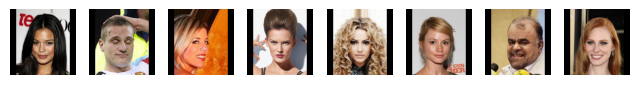

Reconstructed Images


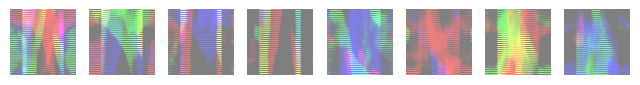

====> Test set loss: -1864939.5595


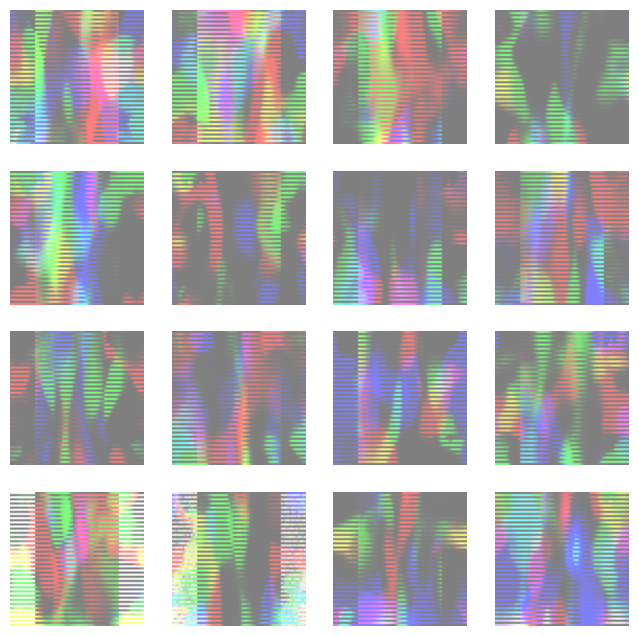

In [ ]:
def visualize_images(images, nrows=4, ncols=4, figsize=(8, 8)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow((images[i].permute(1, 2, 0).detach().cpu().numpy() * 0.5) + 0.5)
        ax.axis('off')
    plt.show()

# Set the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the VAE model
vae = VAE().to(device)

# Load the saved weights
weights_path = 'vae_weights_3.pth'
vae.load_state_dict(torch.load(weights_path, map_location=device))

# Compute the average test loss and visualize the reconstructed images
vae.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = vae(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
            n = min(data.size(0), 8)
            original_images = data[:n]
            reconstructed_images = recon_batch.view(recon_batch.size(0), 3, 64, 64)[:n]
            print("Original Images")
            visualize_images(original_images, nrows=1, ncols=n)
            print("Reconstructed Images")
            visualize_images(reconstructed_images, nrows=1, ncols=n)

test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')

# Generate new images by sampling from the latent space
with torch.no_grad():
    z = torch.randn(16, 100).to(device)
    sample = vae.decoder(z).view(-1, 3, 64, 64)
    visualize_images(sample)
